In [5]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os

In [6]:
temp_diffs = {}
powers = {}
fractions = {}

inputdir = "regions-data/"
filelist = sorted(os.listdir(inputdir))
filelist = [inputdir+f for f in filelist]

df = pd.read_csv(filelist[0])
for reg in df['Region']:
    powers[reg] = []
    temp_diffs[reg] = []
    fractions[reg] = float(df.loc[df['Region'] == reg]['Pixel Count'])/float(df.loc[df['Region'] == 'main']['Pixel Count'])
regions = list(powers.keys())
fractions

{'reg1': 0.03865979381443299,
 'reg2': 0.03865979381443299,
 'reg3': 0.031534263189812006,
 'reg4': 0.03411158277744087,
 'reg5': 0.04639175257731959,
 'main': 1.0}

In [7]:
for f in filelist:
    df = pd.read_csv(f)
    for reg in regions:
        powers[reg].append(float(df.loc[df['Region'] == reg]['Power']))
        temp_diffs[reg].append(float(df.loc[df['Region'] == reg]['Avg T']))

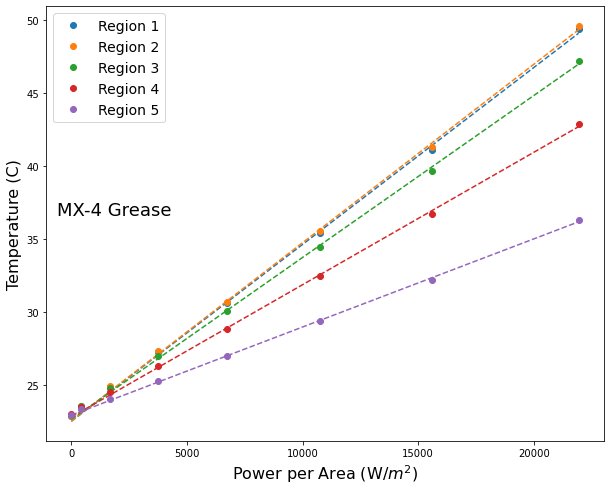

In [12]:
tot_heat_area = 0.02*0.03; #area of heater that actively generates heat (in m^2)

plt.figure(1,(10,8))
slopes = {}
pows_per_area = []
for reg in regions:
    if reg == "main": continue
    pow_per_area = np.array(powers[reg])/tot_heat_area
    dTs = np.array(temp_diffs[reg])
    lab = "Region {0}".format(int(reg[-1]))
    data = plt.plot(pow_per_area,dTs,"o",label=lab)
    x_for_fit = pow_per_area[pow_per_area > 1/tot_heat_area]
    y_for_fit = dTs[pow_per_area > 1/tot_heat_area]
    coeffs = np.polyfit(x_for_fit,y_for_fit,1)
    slopes[reg] = coeffs[0]
    pows_per_area = pow_per_area
    x_fit = np.linspace(np.min(pow_per_area),np.max(pow_per_area),num=50)
    #plt.plot(x_fit,coeffs[0]*x_fit + coeffs[1],"--",color=data[0].get_color(),label="y = {0:.3f}x + {1:.3f}".format(coeffs[0],coeffs[1]))
    plt.plot(x_fit,coeffs[0]*x_fit + coeffs[1],"--",color=data[0].get_color(),label=None)
plt.xlabel(r"Power per Area (W/$m^2$)",fontsize=16)
plt.ylabel("Temperature (C)",fontsize=16)
plt.text(0.02,0.52,"MX-4 Grease",fontsize=18,transform=plt.gca().transAxes)
plt.legend(fontsize=14)
plt.savefig("MX4-PoverA-vs-T.png")

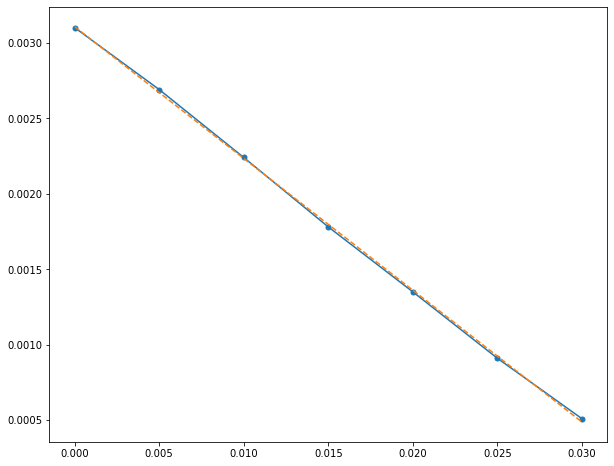

In [9]:
#measured positions along heater, starting from top (deepest) point, in m
heater_y = 0.001*np.array([0,5,10,15,20,25,30,35]) 
#measured depths at corresponding y values, in mm
depths = 0.001*np.array([3.10,2.69,2.24,1.78,1.35,0.91,0.51,0.25]) #measured depths of trench at y positions listed above, in m

#discard last depth point -- measurement was bad
heater_y = heater_y[:-1]
depths = depths[:-1]

#plot and fit trench depth to get prediction of depth for arbitrary y
plt.figure(2,(10,8))
plt.plot(heater_y,depths,marker='.',markersize=10)
fit_params = np.polyfit(heater_y,depths,1)
x_test = np.linspace(heater_y[0],heater_y[-1],num=50)
plt.plot(x_test,fit_params[0]*x_test+fit_params[1],linestyle='--')

depth_m = fit_params[0]
depth_b = fit_params[1]

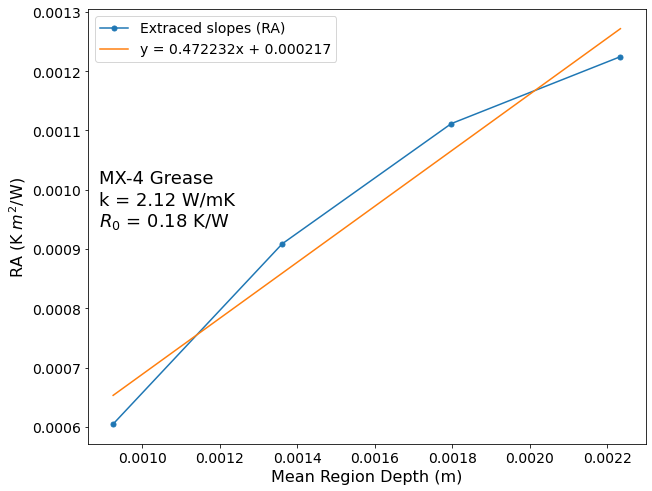

In [15]:
regs_y = 0.001*np.array([5,10,15,20,25]) #y position of centers of reg1, ..., reg6 (in m)
regs_depth = depth_m*regs_y + depth_b
regs = ['reg{0}'.format(i+1) for i in range(len(regs_y))]
slopes_by_depth = np.array([slopes[reg] for reg in regs])

#uppermost region is a bit weird (cooler on avg than region below it -- maybe due to shape of groove at top)
#strike reg1 from the list for now, come back to it later if need be
regs_depth = regs_depth[1:]
slopes_by_depth = slopes_by_depth[1:]

plt.figure(3,(10,8))
plt.plot(regs_depth,slopes_by_depth,marker='.',markersize=10,label="Extraced slopes (RA)")
fit3 = np.polyfit(regs_depth[:],slopes_by_depth[:],1)
plt.plot(regs_depth,fit3[0]*regs_depth + fit3[1],label="y = {0:.6f}x + {1:.6f}".format(fit3[0],fit3[1]))
plt.legend(fontsize=14)
plt.xlabel("Mean Region Depth (m)",fontsize=16)
plt.ylabel(r"RA (K $m^2$/W)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.02,0.60,"MX-4 Grease",fontsize=18,transform=plt.gca().transAxes)
k_tim = 1/fit3[0]
R0 = fit3[1]/(2*tot_heat_area)
plt.text(0.02,0.55,"k = {0:.2f} W/mK".format(k_tim),fontsize=18,transform=plt.gca().transAxes)
plt.text(0.02,0.50,r"$R_0$ = {0:.2f} K/W".format(R0),fontsize=18,transform=plt.gca().transAxes)
plt.savefig("MX4-RA-vs-depth.png")

In [11]:


print("Predicted TIM conductivity = {0}".format(k_tim))
print("Predicted contact impedance = {0}".format(R0))

Predicted TIM conductivity = 2.1176053713477994
Predicted contact impedance = 0.1805492009280808
